In [1]:
# os.chdir(code_dir)
from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
code_dir = os.getcwd()
os.chdir('../..')


In [2]:
cities = ['bal', 'por', 'det', 'phx']
# import data
df = import_data(cities)

# data transformations
df = transform_data(df)

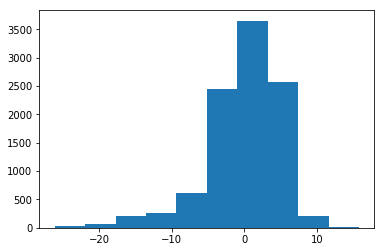

In [3]:
predict_quant = 'lst'
df2 = normalize_response(cities, df, predict_quant)
df2, response = prepare_lst_prediction(df)

response_keys = list(response.keys())
plt.hist(response[response_keys[0]])
plt.show()

# Train on Detroit, test on Baltimore

In [4]:
print(df.shape)
print(response.shape)

(10034, 86)
(10034, 6)


In [5]:
X_train = df2[df2['city']=='det']
X_test = df2[df2['city']=='bal']
y_train = response[df2['city']=='det']
y_test = response[df2['city']=='bal']

# Intra-city holdout

# Feature Selection

How long does it take to run a single regressor with all of the variables?

In [6]:
import time

start = time.time()
###
# train the model
###

df_city = df.copy()
# drop necessary variables
df_city, response = prepare_lst_prediction(df_city)
df_city = df_city.iloc[:,0:20]
variables = df_city.columns.values
print(variables)
# no need to divide, but split into X and y
X_train, X_test, y_train, y_test = train_test_split(df_city, response, test_size=0)#, random_state=RANDOM_SEED)
# scale explanatory variables
X_train, X_train  = scale_X(X_train, X_train)
# response values
y = define_response_lst(y_train, y_train)
# fit the model
gbm = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
gbm.fit(X_train, y['day_train'])

# time
end = time.time()
print(end - start)

['alb_mean_max' 'alb_mean_max_sl' 'alb_mean_mean' 'alb_mean_mean_sl'
 'alb_mean_min' 'alb_mean_min_sl' 'area' 'city' 'elev_max' 'elev_max_sl'
 'elev_mean' 'elev_mean_sl' 'elev_min' 'elev_min_sl' 'imp_max'
 'imp_max_sl' 'imp_mean' 'imp_mean_sl' 'imp_min' 'imp_min_sl']
3.9279065132141113


Given it takes ~6 seconds to fit the largest model, it would take

In [7]:
6*np.sum(range(20))/60

19.0

50 minutes to fit all of the models.
If I took the average MAE from 20 holdouts, that'd take < 20 hours.

In [14]:
import time

start = time.time()
city = 'bal'
period = 'night'
holdout_num = 25
'''
forward selection of variables based on OOB mae
'''
df_set, response = prepare_lst_prediction(df)
variables = df_set.columns.values
variables = [var for var in variables if var not in ['city','area']]
# subset for the city
if city != 'all':
    df_city = df[df['city']==city]
else:
    df_city = df.copy()
# drop necessary variables
df_city, response = prepare_lst_prediction(df_city)
# add variables based on which provide the best improvement to lowering MAE
vars_inc = []
vars_mae = []
while len(vars_inc)<len(variables):
    # loop through the Variables
    variables = [var for var in variables if var not in vars_inc]
    variable_mae = pd.DataFrame(index=variables, columns=['mae'])
    for var in variables:
        df_var = df_city.loc[:,[var,'city'] + vars_inc].copy()
        # initialize error measures
        mae = []
        for h in range(holdout_num):
            # no need to divide, but split into X and y
            X_train, X_test, y_train, y_test = train_test_split(df_var, response, test_size=0.2)#, random_state=RANDOM_SEED)
            # scale explanatory variables
            X_train, X_test  = scale_X(X_train, X_test)
            # response values
            y = define_response_lst(y_train, y_test)
            # fit the model
            gbm_day = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
            gbm_day.fit(X_train, y['{}_train'.format(period)])
            # predict the model
            predict_day = gbm_day.predict(X_test)
            # calculate MAE
            mae.append(np.mean(abs(predict_day - y['{}_test'.format(period)])))
        # calculate the average
        variable_mae.loc[var,'mae'] = np.mean(mae)
    # variable to include
    vars_inc.append(variables[variable_mae.loc[:,'mae'].values.argmin()])
    vars_mae.append(variable_mae.loc[:,'mae'].values.min())
# add to dict
var_forwardstep = pd.DataFrame({
    'variables':vars_inc,
    'mae':vars_mae
})
return(var_forwardstep)
# time
end = time.time()
print(end - start)


2592.4926719665527


In [25]:
vars_mae
val, idx = min((val, idx) for (idx, val) in enumerate(vars_mae))
print(val,idx)

0.3448011188646132 14


In [32]:
var_forwardstep = pd.DataFrame({
    'variables':vars_inc,
    'mae':vars_mae
})
var_forwardstep

,mae,variables
0,0.719181,tree_mean
1,0.484759,ndvi_mean_mean
2,0.408469,elev_min_sl
3,0.362859,tree_max
4,0.354653,ndvi_mean_mean_sl
5,0.349833,tree_max_sl
6,0.349807,elev_mean_sl
7,0.354210,elev_mean
8,0.348039,tree_min
9,0.354165,imp_max


In [30]:
print('number of vars with MAE reported: {}'.format(len(vars_inc)))
# candidate variable number
df_set, response = prepare_lst_prediction(df)
variables = df_set.columns.values
variables = [var for var in variables if var not in ['city','area']]
print('number of candidate vars: {}'.format(len(variables)))

number of vars with MAE reported: 30
number of candidate vars: 30


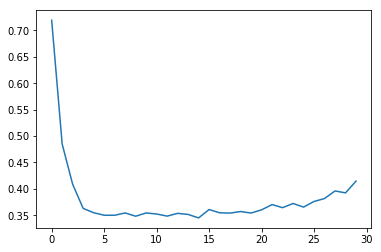

In [26]:
plt.plot(vars_mae)

The time it took for Baltimore night to evaluate all of the variables using a forward greedy algorithm with 25 holdouts, was 

In [27]:
2592/60

43.2

In [35]:
variable_mae

,mae
alb_mean_mean,0.414541


In [ ]:
list(reg_gbm['covariates'])

In [ ]:
cities = ['bal', 'por', 'det', 'phx']
cities = cities.copy()
cities.append('all')
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
# get the covariates - these will be the indices in the dataframe
header = pd.MultiIndex.from_product([['nocturnal','diurnal'],cities],
                                names=['time','city'])
var_imp = pd.DataFrame(columns = header, index = list(reg_gbm['covariates']))
print(var_imp.shape)
for city in cities:
    for time in ['diurnal','nocturnal']:
        var_imp.loc[:,(time, city)] = reg_gbm[time][city].feature_importances_
var_imp.loc[:,('nocturnal','mean')] = np.mean(var_imp.loc[:,'nocturnal'].drop('all',axis=1),axis=1)
var_imp = var_imp.sort_values(by=('nocturnal','mean'),ascending=False)
# make the nocturnal values negative
nocturnal = var_imp.loc[:,'nocturnal'].copy()
nocturnal = nocturnal.drop('mean',axis=1)
nocturnal['covariate'] = nocturnal.index
nocturnal = pd.melt(nocturnal,id_vars=['covariate'])
nocturnal.loc[:,'value'] = nocturnal['value'] * -1
# diurnal
diurnal = var_imp.loc[:,'diurnal'].copy()
diurnal.loc[:,'covariate'] = diurnal.index
diurnal = pd.melt(diurnal,id_vars=['covariate'])
# plot
ax = sns.barplot(orient="h", y='covariate', x='value',hue='city', data=nocturnal, palette = five_thirty_eight)

ax = sns.barplot(orient="h", y='covariate', x='value',hue='city', data=diurnal, palette = five_thirty_eight)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Variable Importance')
plt.ylabel('Variables')
l = plt.legend(handles[0:4], labels[0:4], loc='lower right')
# mpl.rcParams['figure.figsize'] = 10, 20
# zero line
plt.axvline(x=0, color='k', linestyle='-', linewidth = 2)
plt.xlim(-0.2,0.2)

plt.show()
# plt.clf()


In [36]:
cities = ['bal', 'por', 'det', 'phx']
for city in cities+['all']:
    print(city)

bal
por
det
phx
all


In [37]:
from datetime import datetime
print('{}: completed {}, {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), city, period))

2018-04-25 00:07:39: completed all, night


In [39]:
import pickle
with open('data/variable_selection.pkl', 'wb') as f:
    pickle.dump(var_forwardstep, f, pickle.HIGHEST_PROTOCOL)